# Solution to Labs: Visualize Financial Data - Remade in Quantopian

*Comparing FANG Stocks With S&P 500*

In this project, we will analyze the returns of high-performing technology stocks - Facebook, Amazon, Netflix, and Google and compare them with the returns of S&P 500 index.

In [1]:
# Do not change anything in this code cell.

import matplotlib.pyplot as plt
from datetime import date

# All Quantopian modules that we need in this project

# StaticAssets to get specific stocks
from quantopian.pipeline.filters import StaticAssets

# Get DailyReturns from a built-in factor
from quantopian.pipeline.factors import DailyReturns

# Customizable Pipeline object
from quantopian.pipeline import Pipeline

# Function to run a pipeline object
from quantopian.research import run_pipeline

start_date = '2014-01-02'
end_date = '2019-10-31' 

tickers = ['SPY', 'FB', 'AMZN', 'NFLX', 'GOOG']

## 1. Download Percentage Returns Data

With Quantopian, we can directly convert pricing data into percentage returns with this built in factor [quantopian.pipeline.factors.DailyReturns](https://www.quantopian.com/docs/api-reference/pipeline-api-reference#quantopian.pipeline.factors.DailyReturns).

<div class="alert alert-info">
    Keep in mind that, since we use a different data source from QuoteMedia, the values could be wildly different from the values that we got in the first project. Adjusted close price of SPY on date 2014-01-02, for example, is \$184.56 for Quantopian data, and \$163.38 for QuoteMedia data.
</div>

In [2]:
# Quick check on pricing difference.

from quantopian.pipeline.data.builtin import USEquityPricing

def universe():
    # Todo: Get tickers using StaticAssets
    return StaticAssets(symbols(tickers))

def make_pipeline():        
    # Todo: Get the latest price of USEquityPricing
    price = USEquityPricing.close.latest
    
    # Todo: Return a pipeline object
    return Pipeline(
        columns={
            'price': price
        },
        screen=universe()
    )


p_pipe = make_pipeline()

# mdf = multi-index dataframe
p_mdf = run_pipeline(p_pipe, start_date, start_date)
p_mdf

price
2014-01-02 00:00:00+00:00 Equity(8554 [SPY])    184.56
                          Equity(16841 [AMZN])  398.47
                          Equity(23709 [NFLX])  368.15
                          Equity(42950 [FB])     54.66

In [3]:
def make_pipeline():        
    
    u = universe()
    
    # Todo: Create an instance of DailyReturns. Don't forget
    #       to set `mask` argument to the universe instance (`u`).
    percent_returns = DailyReturns(mask=u)
    
    # Todo: Return a pipeline object.
    return Pipeline(
        columns={
            'percent_returns': percent_returns
        },
        screen=u
    )


rp_pipe = make_pipeline()

# mdf = multi-index dataframe
rp_mdf = run_pipeline(rp_pipe, start_date, end_date)

### Unstack

Unstack the DataFrame so we may properly present it (i.e. grouped by stock symbols).

In [4]:
# Before unstack
rp_mdf.head(10)

percent_returns
2014-01-02 00:00:00+00:00 Equity(8554 [SPY])           0.004080
                          Equity(16841 [AMZN])         0.012965
                          Equity(23709 [NFLX])         0.003161
                          Equity(42950 [FB])           0.017877
2014-01-03 00:00:00+00:00 Equity(8554 [SPY])          -0.008723
                          Equity(16841 [AMZN])        -0.001255
                          Equity(23709 [NFLX])        -0.013989
                          Equity(42950 [FB])           0.001098
2014-01-06 00:00:00+00:00 Equity(8554 [SPY])          -0.000875
                          Equity(16841 [AMZN])        -0.003995

In [5]:
# After unstack (i.e. flat dataframe)
rp_df = rp_mdf.unstack()
rp_df.iloc[0,:] = 0
rp_df.head(5)

percent_returns                       \
                          Equity(8554 [SPY]) Equity(16841 [AMZN])   
2014-01-02 00:00:00+00:00           0.000000             0.000000   
2014-01-03 00:00:00+00:00          -0.008723            -0.001255   
2014-01-06 00:00:00+00:00          -0.000875            -0.003995   
2014-01-07 00:00:00+00:00          -0.002134            -0.007367   
2014-01-08 00:00:00+00:00           0.005757             0.011640   

                                                                   \
                          Equity(23709 [NFLX]) Equity(42950 [FB])   
2014-01-02 00:00:00+00:00             0.000000           0.000000   
2014-01-03 00:00:00+00:00            -0.013989           0.001098   
2014-01-06 00:00:00+00:00             0.000248          -0.002924   
2014-01-07 00:00:00+00:00            -0.010163           0.048021   
2014-01-08 00:00:00+00:00            -0.055760           0.013116   

                                                
                          Equity(46631 [GOOG])  
2014-01-02 00:00:00+00:00                  0.0  
2014-01-03 00:00:00+00:00                  NaN  
2014-01-06 00:00:00+00:00                  NaN  
2014-01-07 00:00:00+00:00                  NaN  
2014-01-08 00:00:00+00:00                  NaN

Notice that it took way fewer steps to gather the data and compute the stock return percentages. With the result that we have gotten, you may simply process the DataFrame to produce the visualizations as you did for the first project. You may copy all the code cells starting from section "4. Plot Daily Return Percentages and Their Distributions" all the way to the end of the notebook document.

---

## 2. Factor to calculate cumulative returns

Rather than calculating from `rp_df` DataFrame like you have done for Project 1, let's create a Pipeline to calculate this for us. This way we can reuse this class for building a trading algorithm.

In [6]:
from datetime import datetime

# We only need numpy later for counting business days.
import numpy as np

from quantopian.pipeline.factors import DailyReturns
from quantopian.pipeline import CustomFactor

# Calculate 1 month cumulative returns
window = 22
u = universe()

class CumulativeReturnPercentages(CustomFactor):
    def compute(self, today, assets, out, data):
        # Todo: +1 to data, calculate cumprod on its rows, then
        # get the last values of cumprod
        out[:] = ((data+1).cumprod(axis=0)-1)[-1]

# Todo: Create an instance of CumultiveReturnPercentages.
#       Warning! Make sure to set `mask` parameter or otherwise
#       it will take a considerable amount of time to calculate.
crp = CumulativeReturnPercentages(inputs=[DailyReturns()], window_length=window, mask=u)


# Todo: Create a Pipeline instance that uses `crp` variable as
#       its column. Don't forget to set the `screen` argument.
cumrp_pipe = Pipeline(  
    columns={  
        'cum_return': crp
    },  
    screen=u,  
)

cumrp_mdf = run_pipeline(cumrp_pipe, start_date, end_date)

In [7]:
cumrp_df = cumrp_mdf.unstack()

## 3. Plot Cumulative Returns

And finally, plot the cumulative returns. Note that, since the factor calculates 22 days cumulative return for each day, the plot will not *look* cumulative. We expect to se a plot with changing values throughout its days.

In [8]:
cumrp_df.head(5)

cum_return                       \
                          Equity(8554 [SPY]) Equity(16841 [AMZN])   
2014-01-02 00:00:00+00:00           0.024412             0.030704   
2014-01-03 00:00:00+00:00           0.016823             0.010871   
2014-01-06 00:00:00+00:00           0.018016             0.010400   
2014-01-07 00:00:00+00:00           0.019458             0.022877   
2014-01-08 00:00:00+00:00           0.026439             0.031512   

                                                                   \
                          Equity(23709 [NFLX]) Equity(42950 [FB])   
2014-01-02 00:00:00+00:00             0.015614           0.175484   
2014-01-03 00:00:00+00:00            -0.007953           0.164008   
2014-01-06 00:00:00+00:00            -0.002418           0.159125   
2014-01-07 00:00:00+00:00            -0.009481           0.223625   
2014-01-08 00:00:00+00:00            -0.047731           0.191240   

                                                
                          Equity(46631 [GOOG])  
2014-01-02 00:00:00+00:00                  NaN  
2014-01-03 00:00:00+00:00                  NaN  
2014-01-06 00:00:00+00:00                  NaN  
2014-01-07 00:00:00+00:00                  NaN  
2014-01-08 00:00:00+00:00                  NaN

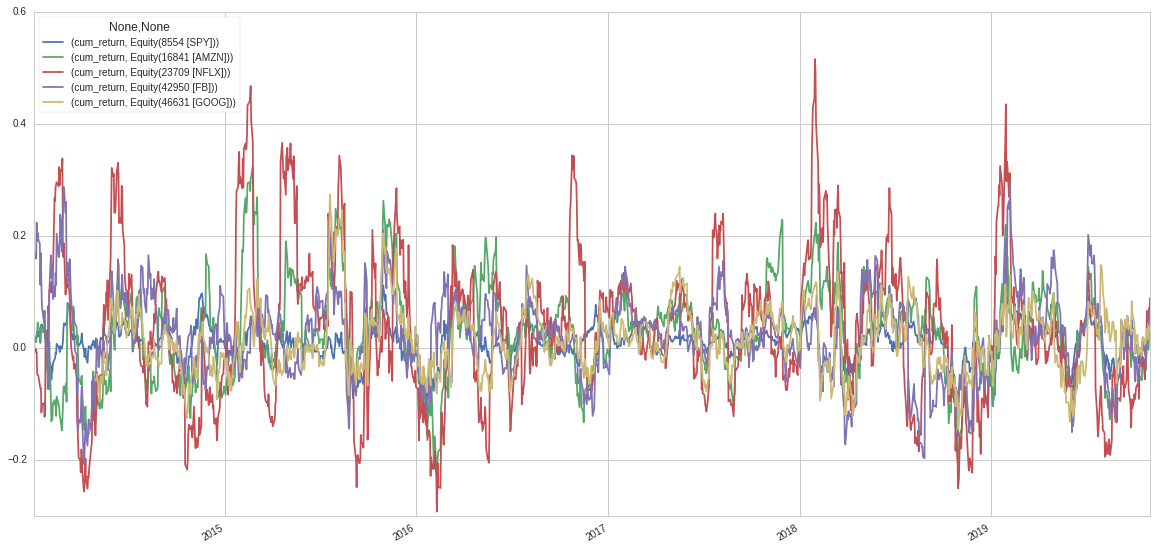

In [9]:
# Todo: Plot cumulative returns.
_ = cumrp_df.plot(figsize=(20, 10))

## Conclusion

In this exercise, you have created a pipeline that can be used to produce a trading signal should you choose to. In a later lesson, you will learn a systematic method to measure the statistical significance of your signals, but for the next lesson, let's take a look at another way to include external data points into your pipeline, which will potentially help you gain an edge in finding good signals: Self-Serve Data.